# import Libraries

In [84]:
import os
import cv2
import time
import glob
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.utils import resample
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization,MaxPooling2D,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.layers import Conv2D,Dense,Dropout,GlobalAveragePooling2D,MaxPool2D
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

# Load dataset
Load all paths in list

In [4]:
data_dir='/kaggle/input/chest-xray-pneumonia/chest_xray'
paths=glob.glob(data_dir+'/*/*/*.jpeg')
print(f'found {len(paths)} images in the dataset')
paths[:5]

found 5856 images in the dataset


['/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg']

now load them in dataframe and extract label from path

In [5]:
df=pd.DataFrame(paths,columns=['path'])
df['label']=df['path'].apply(lambda x:x.split('/')[6].strip())
df.head()

,path,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


# EDA

In [6]:
counts=df['label'].value_counts()
counts

label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

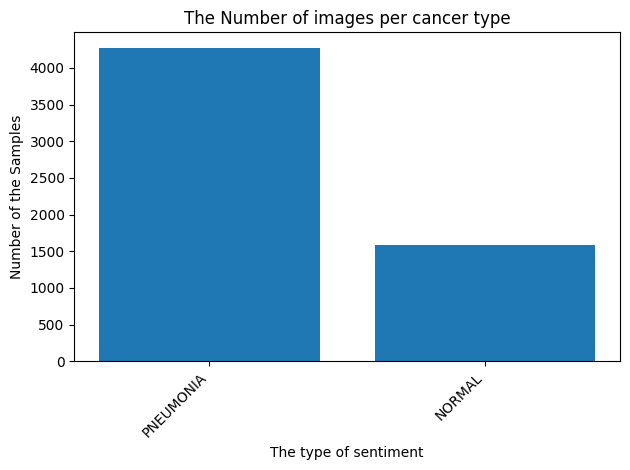

In [7]:
plt.bar(['PNEUMONIA','NORMAL'], counts, width=0.8)
plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of images per cancer type")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

## Plot some images

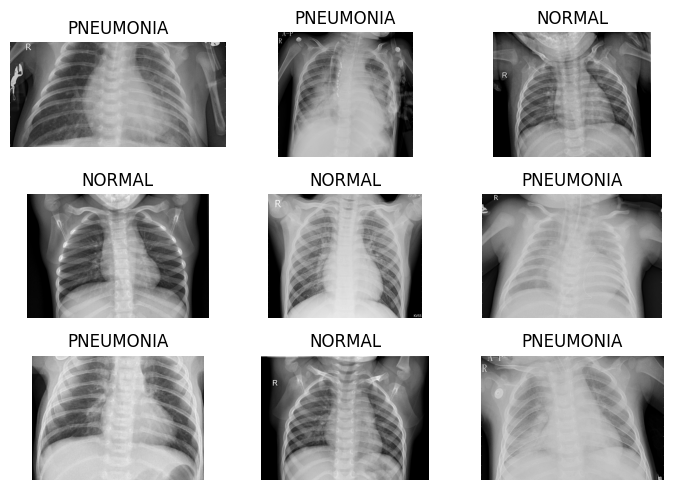

In [8]:
num_images=9

sampled_df = df.sample(n=num_images).reset_index(drop=True)

plt.figure(figsize=(7, 5))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)

    # Read the image
    img_path = sampled_df.iloc[i]['path']
    img = plt.imread(img_path)

    plt.imshow(img,cmap='gray')
    plt.title(sampled_df.iloc[i]['label'])
    plt.axis('off')

plt.tight_layout()
plt.show()

note that image snot have the same size 

# Handle Imbalancing

### We see the data is imbalnced we used Downsampling :
- we Reduce the number of instances in the majority class (PNEUMONIA) to match the number of instances in the minority class (NORMAL).

In [9]:
df_majority = df[df.label == 'PNEUMONIA']
df_minority = df[df.label == 'NORMAL']

In [10]:

df_majority_downsampled = resample(df_majority,
                                   replace=False,  
                                   n_samples=len(df_minority), 
                                   random_state=42)  


df = pd.concat([df_minority, df_majority_downsampled])

In [11]:
counts=df['label'].value_counts()
counts

label
NORMAL       1583
PNEUMONIA    1583
Name: count, dtype: int64

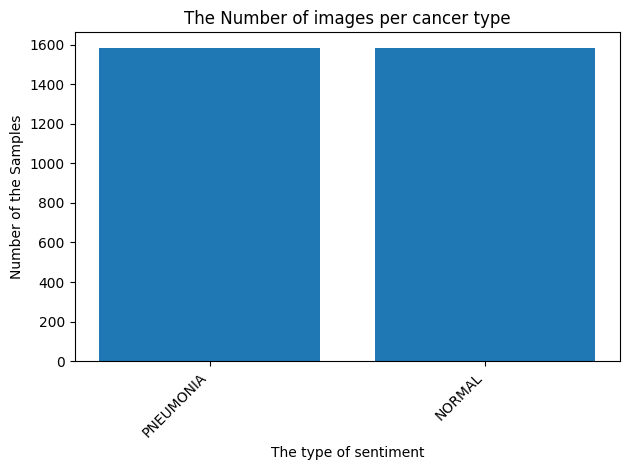

In [12]:
plt.bar(['PNEUMONIA','NORMAL'], counts, width=0.8)
plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of images per cancer type")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

### Convert labels to binary values

In [13]:
df

,path,label
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
10,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
11,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
12,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
...,...,...
4473,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3774,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3781,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3370,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


In [14]:
df['label'] = df['label'].apply(lambda x: '1' if x == 'PNEUMONIA' else '0')
df.head()

,path,label
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
10,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
11,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
12,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0


In [15]:
df['label'].value_counts()

label
0    1583
1    1583
Name: count, dtype: int64

### shuffle tha data

In [16]:
df=df.sample(frac=1.0, random_state=42)
df.head(5)

,path,label
4837,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
5603,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
568,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
1101,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
117,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1


# Split data

In [17]:

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Training set shapes:", train_df.shape)
print("Validation set shapes:", valid_df.shape)
print("Testing set shapes:", test_df.shape)

Training set shapes: (2532, 2)
Validation set shapes: (317, 2)
Testing set shapes: (317, 2)


In [18]:
train_df['label'].value_counts()


label
1    1277
0    1255
Name: count, dtype: int64

# Data Generattors

In [20]:
train_datagen = ImageDataGenerator(    
    rescale=1.0/255,        
#     shear_range=0.2,
#     rotation_range=.1,
#     zoom_range=0.2,       
#     horizontal_flip=True ,
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path', 
    y_col='label',   
    target_size=(150, 150), 
    batch_size=32,
    class_mode='binary', 
    color_mode='rgb',
    shuffle=True
)


valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path', 
    y_col='label',
    target_size=(150, 150), 
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False  
)


test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path', 
    y_col='label',  
    target_size=(150, 150),  
    color_mode='rgb',
    batch_size=64,  
    class_mode='binary',
    shuffle=False  
)

Found 2532 validated image filenames belonging to 2 classes.
Found 317 validated image filenames belonging to 2 classes.
Found 317 validated image filenames belonging to 2 classes.


get class names

In [22]:
classes=['NORMAL','PNEUMONIA']
classes

['NORMAL', 'PNEUMONIA']

plot some images after resizing and Augementation

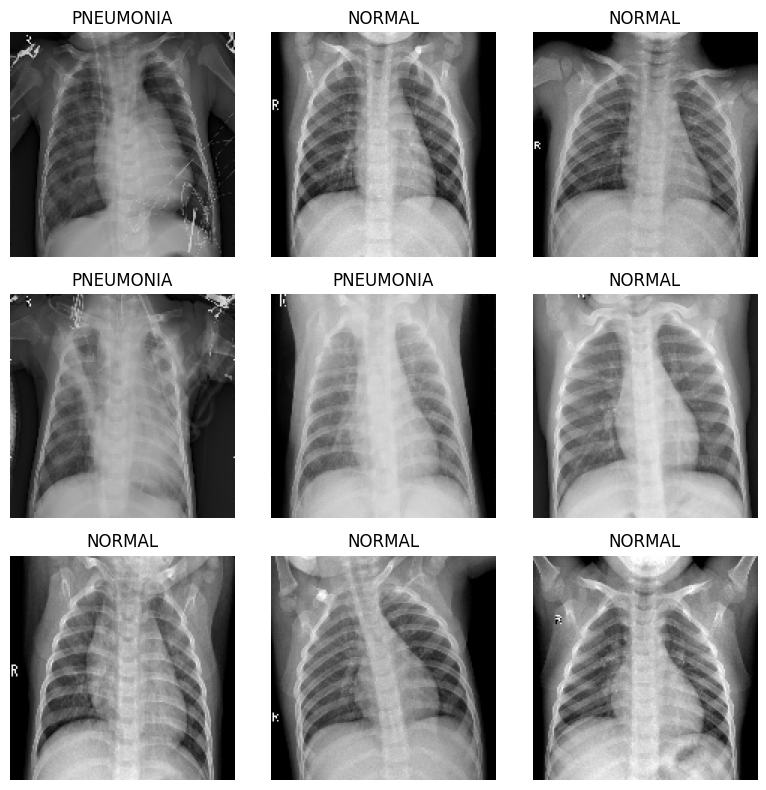

In [23]:
batch_size = 9

images, labels = next(train_generator)

plt.figure(figsize=(8, 8))
for i in range(min(len(images), 9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i],cmap='gray')
    plt.title(f"{classes[int(labels[i])]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# MobileNet

In [24]:
train_generator.image_shape

(150, 150, 3)

In [89]:
model = keras.models.Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,977 (4.76 MB)

 Trainable params: 1,245,889 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [90]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [91]:
cnn_start_time = time.time()
history = model.fit(train_generator ,epochs = 12 ,validation_data=valid_generator,callbacks = [learning_rate_reduction])
cnn_end_time = time.time()
cnn_training_time = (cnn_end_time - cnn_start_time) / 60

Epoch 1/12
 1/80 ━━━━━━━━━━━━━━━━━━━━ 14:29 11s/step - accuracy: 0.4375 - loss: 1.4431

W0000 00:00:1732562074.799079     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7598 - loss: 2.4665

W0000 00:00:1732562104.513342     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1732562106.293465     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 437ms/step - accuracy: 0.7612 - loss: 2.4306 - val_accuracy: 0.4890 - val_loss: 14.9384 - learning_rate: 0.0010
Epoch 2/12


W0000 00:00:1732562109.327513     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 336ms/step - accuracy: 0.8806 - loss: 0.3934 - val_accuracy: 0.4890 - val_loss: 4.5828 - learning_rate: 0.0010
Epoch 3/12
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9189 - loss: 0.2130
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 334ms/step - accuracy: 0.9190 - loss: 0.2127 - val_accuracy: 0.4890 - val_loss: 12.7041 - learning_rate: 0.0010
Epoch 4/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 339ms/step - accuracy: 0.9522 - loss: 0.1225 - val_accuracy: 0.4890 - val_loss: 8.6770 - learning_rate: 3.0000e-04
Epoch 5/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9672 - loss: 0.0834
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 339ms/step - accuracy: 0.9672 - loss: 0.0836 - val_accuracy: 0.4890 - val_loss: 6.4380 - learning_rate: 3.0000e-04
Epoch 6/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 340ms/step - accuracy: 0.9776 - loss: 0.0687 -

In [93]:
print(f"Training Time: {cnn_training_time:.2f} minutes")


Training Time: 6.21 minutes


In [94]:
evaluation_result = model.evaluate(test_generator)


print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9688 - loss: 0.0585

W0000 00:00:1732562516.599383     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 631ms/step - accuracy: 0.9673 - loss: 0.1111
Test Loss: 0.1264721304178238
Test Accuracy: 0.9684542417526245


In [95]:
y_pred = model.predict(test_generator)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 668ms/step


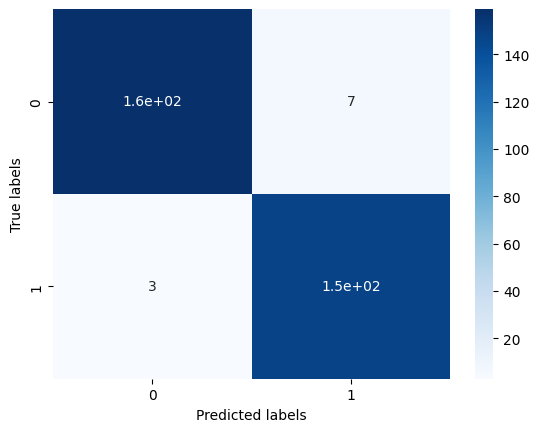

In [96]:
y_pred_binary = np.squeeze(np.round(y_pred))

confusion_Matrix = confusion_matrix(test_generator.classes, y_pred_binary)
confusion_Matrix

sns.heatmap(confusion_Matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

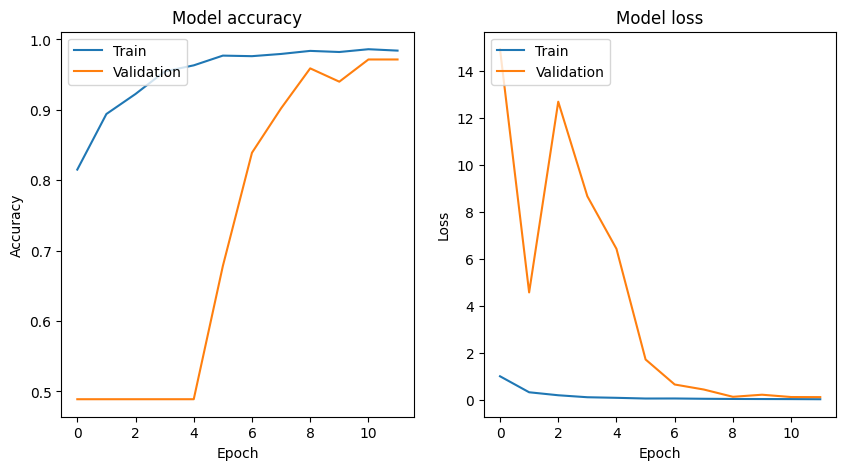

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')


ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')


plt.show()

In [99]:
cnn_pred_binary = np.squeeze(np.round(y_pred))
print(classification_report(test_generator.classes, cnn_pred_binary))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       166
           1       0.95      0.98      0.97       151

    accuracy                           0.97       317
   macro avg       0.97      0.97      0.97       317
weighted avg       0.97      0.97      0.97       317



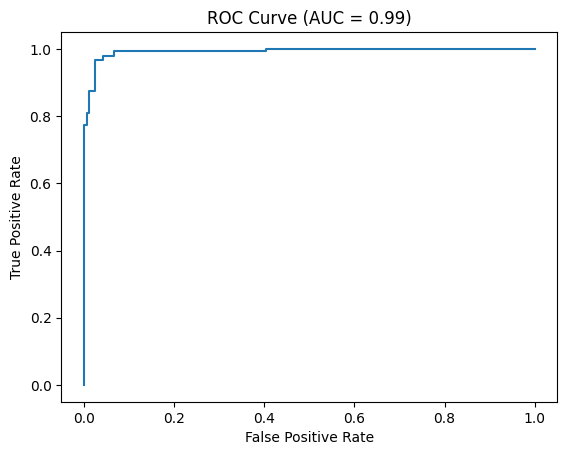

In [101]:
from sklearn.metrics import roc_curve, roc_auc_score



fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred)


auc_score = roc_auc_score(test_generator.classes, y_pred)


import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


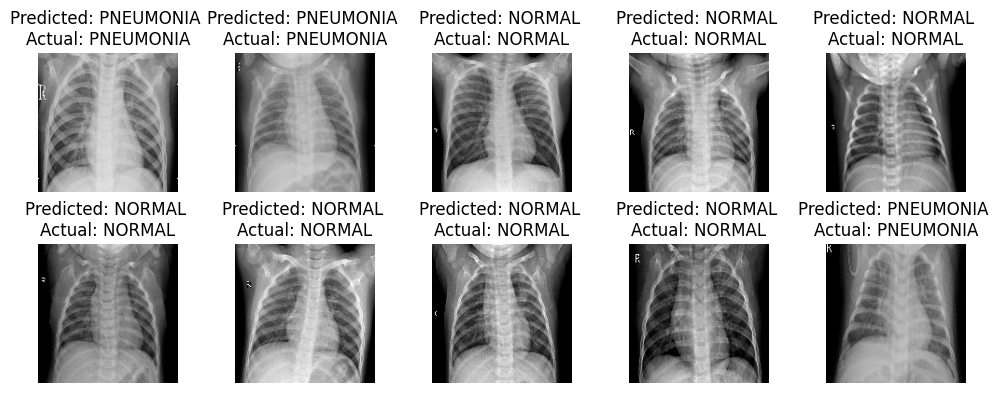

In [102]:
x_test,y_test=next(test_generator)
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()

for i in range(10):
    predicted = model.predict(np.array([x_test[i]]))
    predictedClass = int(predicted >= 0.5)
    actual = int(y_test[i])

    axs[i].imshow(x_test[i], cmap='gray')
    axs[i].set_title(f'Predicted: {classes[predictedClass]} \nActual: {classes[actual]}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [105]:
from keras.applications import MobileNetV2
mobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in mobileNetV2.layers:
    layer.trainable = False


model

In [106]:
mobileNet=keras.models.Sequential([
    mobileNetV2,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'), 
    Dropout(0.5),  
    Dense(1, activation='sigmoid') 
])

mobileNet.add(Dense(1,activation='sigmoid'))
mobileNet.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [107]:
mobileNet.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [109]:
weight_path = "cnn_weights.best.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

early = EarlyStopping(monitor="val_accuracy", 
                      mode="max", 
                      patience=4)

callbacks_list = [checkpoint, early]

In [110]:
mobilenet_start_time = time.time()
mobileNet_history=mobileNet.fit(train_generator,epochs=12,validation_data=valid_generator,callbacks=callbacks_list)
mobilenet_end_time = time.time()
mobilenet_training_time = (mobilenet_end_time - mobilenet_start_time) / 60

Epoch 1/12
 1/80 ━━━━━━━━━━━━━━━━━━━━ 13:54 11s/step - accuracy: 0.5000 - loss: 0.7340

W0000 00:00:1732562895.974656     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 5/80 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.5506 - loss: 0.6866  

W0000 00:00:1732562900.420202     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7243 - loss: 0.5895

W0000 00:00:1732562926.256117     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.93375, saving model to cnn_weights.best.weights.h5


W0000 00:00:1732562930.355380     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 439ms/step - accuracy: 0.7268 - loss: 0.5886 - val_accuracy: 0.9338 - val_loss: 0.5174
Epoch 2/12
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9089 - loss: 0.5146
Epoch 2: val_accuracy improved from 0.93375 to 0.94637, saving model to cnn_weights.best.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 335ms/step - accuracy: 0.9091 - loss: 0.5146 - val_accuracy: 0.9464 - val_loss: 0.4997
Epoch 3/12
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9259 - loss: 0.5000
Epoch 3: val_accuracy did not improve from 0.94637
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 336ms/step - accuracy: 0.9260 - loss: 0.4998 - val_accuracy: 0.9464 - val_loss: 0.4808
Epoch 4/12
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9286 - loss: 0.4869
Epoch 4: val_accuracy did not improve from 0.94637
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 338ms/step - accuracy: 0.9286 - loss: 0.4868 - val_accuracy: 0.9306 - val_loss: 0.4759
Epoch 5/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.92

In [111]:
print(f"Training Time: {mobilenet_training_time:.2f} minutes")

Training Time: 5.66 minutes


In [112]:

mobileNet.load_weights(weight_path)

# Evaluate model

In [114]:

evaluation_result = mobileNet.evaluate(test_generator)


print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step - accuracy: 0.9366 - loss: 0.4357
Test Loss: 0.4443672299385071
Test Accuracy: 0.9242902398109436


## MobileNet Confusion Matrix

In [115]:
y_pred = mobileNet.predict(test_generator)

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step  


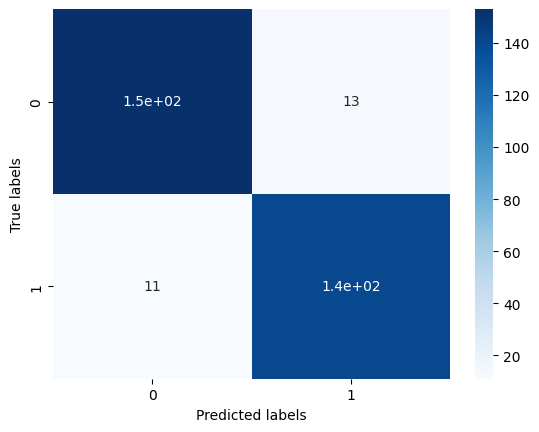

In [116]:
y_pred_binary = np.squeeze(np.round(y_pred))

confusion_Matrix = confusion_matrix(test_generator.classes, y_pred_binary)
confusion_Matrix

sns.heatmap(confusion_Matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Training and Validation performance

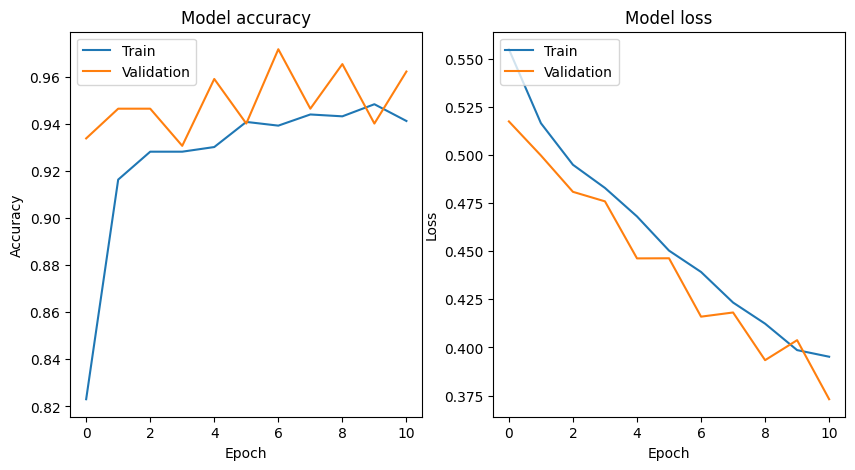

In [117]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(mobileNet_history.history['accuracy'])
ax1.plot(mobileNet_history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')


ax2.plot(mobileNet_history.history['loss'])
ax2.plot(mobileNet_history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')


plt.show()

## Classification Report

In [118]:
mobilenet_pred_binary = np.squeeze(np.round(y_pred))
print(classification_report(test_generator.classes, mobilenet_pred_binary))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       166
           1       0.92      0.93      0.92       151

    accuracy                           0.92       317
   macro avg       0.92      0.92      0.92       317
weighted avg       0.92      0.92      0.92       317



## MobileNet AUC curve for binary classification

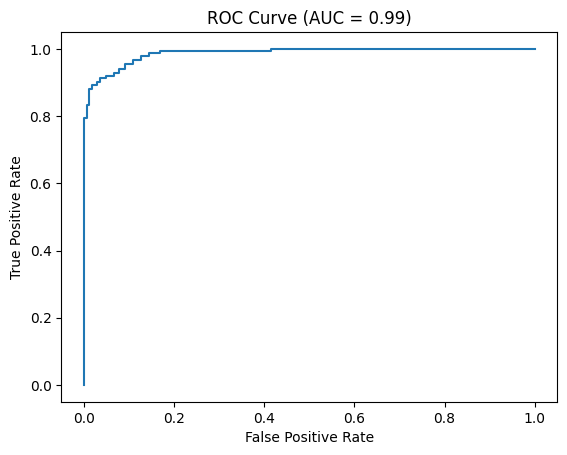

In [120]:
from sklearn.metrics import roc_curve, roc_auc_score



fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred)


auc_score = roc_auc_score(test_generator.classes, y_pred)


import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
plt.show()

# Test the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


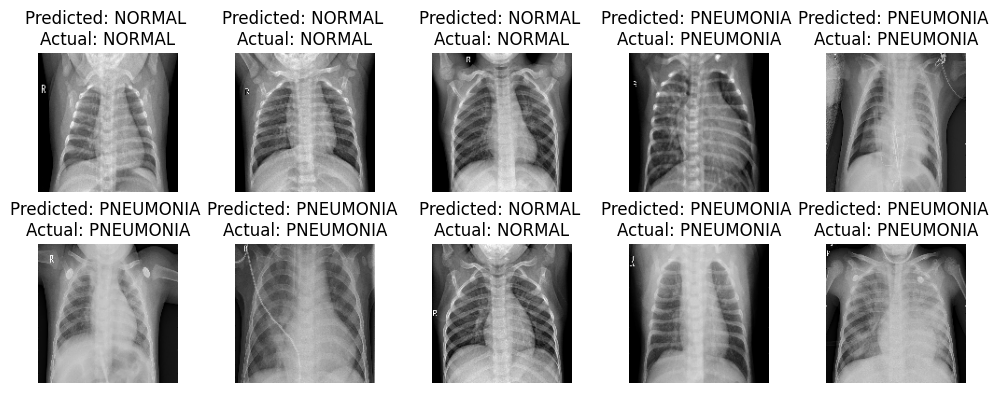

In [121]:
x_test,y_test=next(test_generator)
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()

for i in range(10):
    predicted = mobileNet.predict(np.array([x_test[i]]))
    predictedClass = int(predicted >= 0.5)
    actual = int(y_test[i])

    axs[i].imshow(x_test[i], cmap='gray')
    axs[i].set_title(f'Predicted: {classes[predictedClass]} \nActual: {classes[actual]}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [124]:
from keras.applications import VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


for layer in vgg16.layers:
    layer.trainable = False

In [125]:
vgg_model = keras.models.Sequential([
    vgg16,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])
vgg_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [126]:
vgg_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [128]:

weight_path = "vgg16_weights.best.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

early = EarlyStopping(monitor="val_accuracy", 
                      mode="max", 
                      patience=4)

callbacks_list = [checkpoint, early]

In [129]:
vgg16_start_time = time.time()
vgg16_history = vgg_model.fit(
    train_generator,
    epochs=12,
    validation_data=valid_generator,
    callbacks=callbacks_list
)
vgg16_end_time = time.time()
vgg16_training_time = (vgg16_end_time - vgg16_start_time) / 60

Epoch 1/12
35/80 ━━━━━━━━━━━━━━━━━━━━ 15s 347ms/step - accuracy: 0.5586 - loss: 0.7271

W0000 00:00:1732563518.792364     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.6424 - loss: 0.6444
Epoch 1: val_accuracy improved from -inf to 0.89905, saving model to vgg16_weights.best.weights.h5


W0000 00:00:1732563537.125286     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 382ms/step - accuracy: 0.6437 - loss: 0.6430 - val_accuracy: 0.8991 - val_loss: 0.3430
Epoch 2/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8714 - loss: 0.3565
Epoch 2: val_accuracy improved from 0.89905 to 0.91483, saving model to vgg16_weights.best.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 354ms/step - accuracy: 0.8715 - loss: 0.3562 - val_accuracy: 0.9148 - val_loss: 0.2498
Epoch 3/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8898 - loss: 0.2805
Epoch 3: val_accuracy did not improve from 0.91483
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 349ms/step - accuracy: 0.8898 - loss: 0.2805 - val_accuracy: 0.8991 - val_loss: 0.2408
Epoch 4/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8949 - loss: 0.2797
Epoch 4: val_accuracy improved from 0.91483 to 0.93060, saving model to vgg16_weights.best.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 349ms/step - accuracy: 0.8949 - loss: 0.2795 - val_accuracy: 0.9306 - val_loss: 0.1918
Epoch 5/12
80/8

In [130]:
print(f"Training Time: {vgg16_training_time:.2f} minutes")

Training Time: 6.16 minutes


In [133]:
vgg_model.load_weights(weight_path)

In [134]:

evaluation_result = vgg_model.evaluate(test_generator)


print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 677ms/step - accuracy: 0.9467 - loss: 0.1432
Test Loss: 0.16139590740203857
Test Accuracy: 0.9337539672851562


W0000 00:00:1732563909.176361     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [135]:
y_pred = vgg_model.predict(test_generator)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 674ms/step


W0000 00:00:1732563950.853891     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


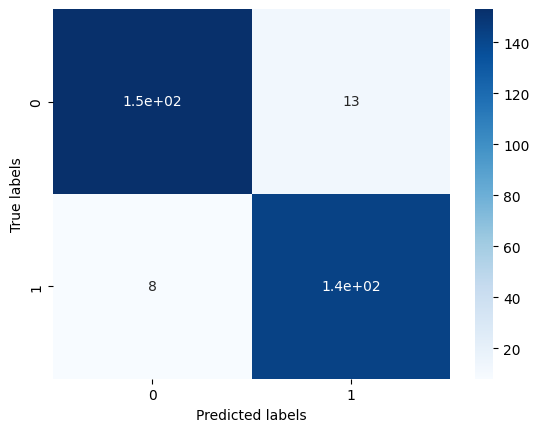

In [136]:
y_pred_binary = np.squeeze(np.round(y_pred))

confusion_Matrix = confusion_matrix(test_generator.classes, y_pred_binary)
confusion_Matrix

sns.heatmap(confusion_Matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

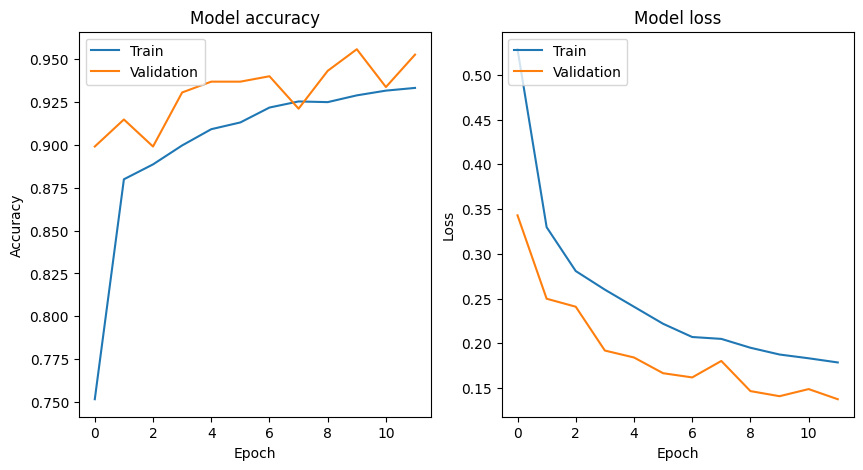

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(vgg16_history.history['accuracy'])
ax1.plot(vgg16_history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')


ax2.plot(vgg16_history.history['loss'])
ax2.plot(vgg16_history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')


plt.show()

In [140]:
vgg16_pred_binary = np.squeeze(np.round(y_pred))
print(classification_report(test_generator.classes, vgg16_pred_binary))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       166
           1       0.92      0.95      0.93       151

    accuracy                           0.93       317
   macro avg       0.93      0.93      0.93       317
weighted avg       0.93      0.93      0.93       317



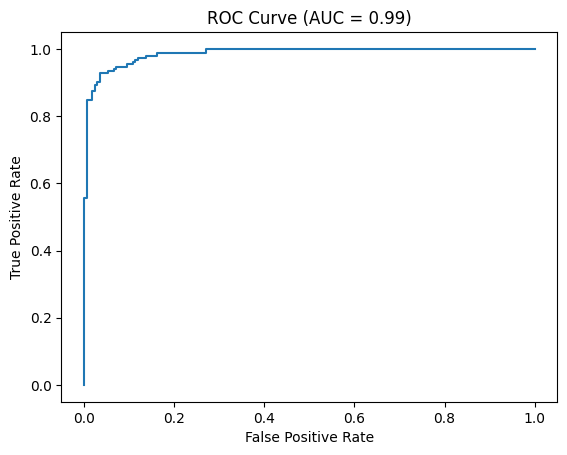

In [141]:
from sklearn.metrics import roc_curve, roc_auc_score



fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred)


auc_score = roc_auc_score(test_generator.classes, y_pred)


import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


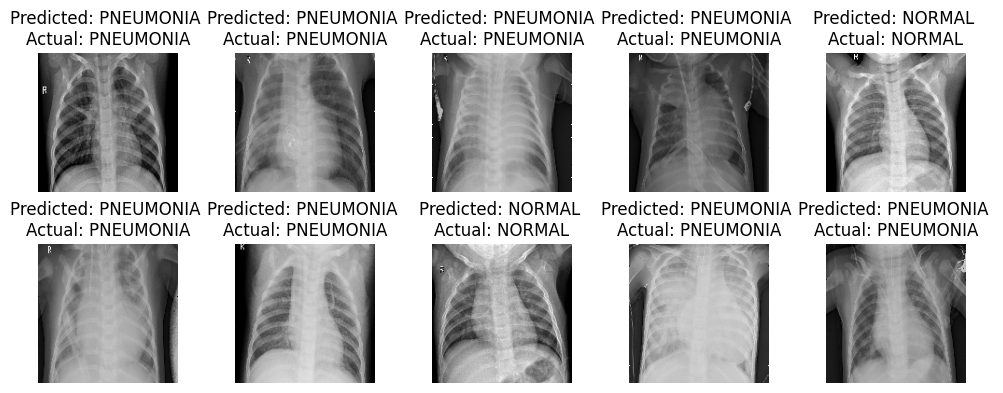

In [142]:
x_test,y_test=next(test_generator)
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()

for i in range(10):
    predicted = vgg_model.predict(np.array([x_test[i]]))
    predictedClass = int(predicted >= 0.5)
    actual = int(y_test[i])

    axs[i].imshow(x_test[i], cmap='gray')
    axs[i].set_title(f'Predicted: {classes[predictedClass]} \nActual: {classes[actual]}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


## Comparison between 3 models


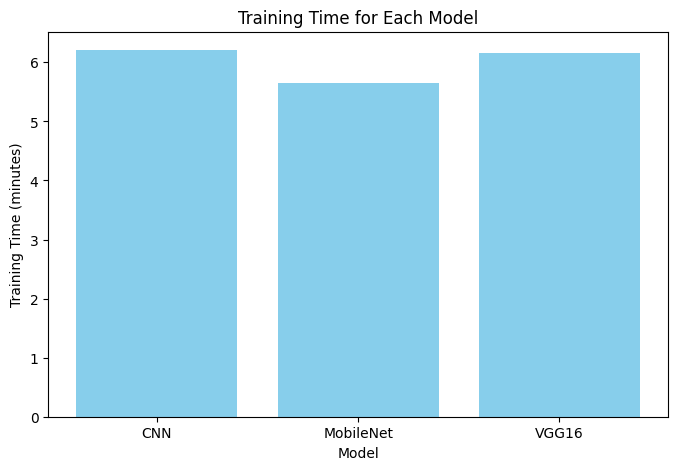

In [146]:
models = ["CNN", "MobileNet", "VGG16"]
training_times = [cnn_training_time, mobilenet_training_time, vgg16_training_time]  
plt.figure(figsize=(8, 5))
plt.bar(models, training_times, color='skyblue')
plt.title("Training Time for Each Model")
plt.xlabel("Model")
plt.ylabel("Training Time (minutes)")
plt.show()

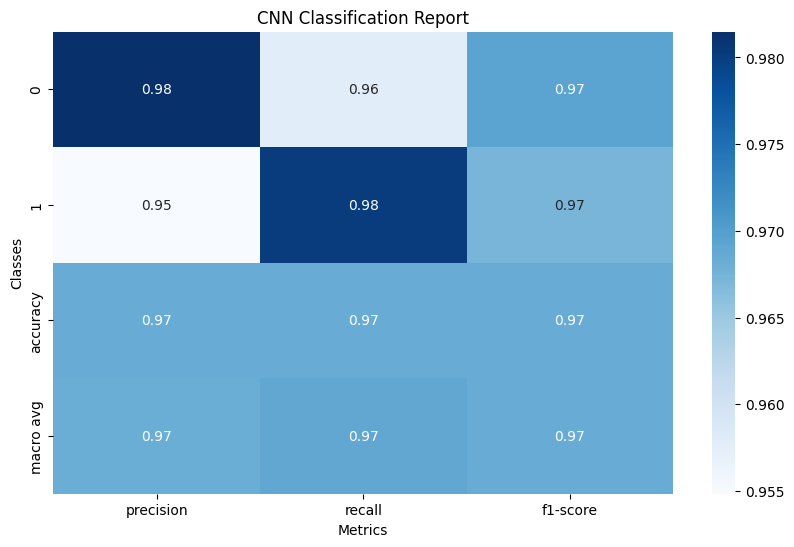

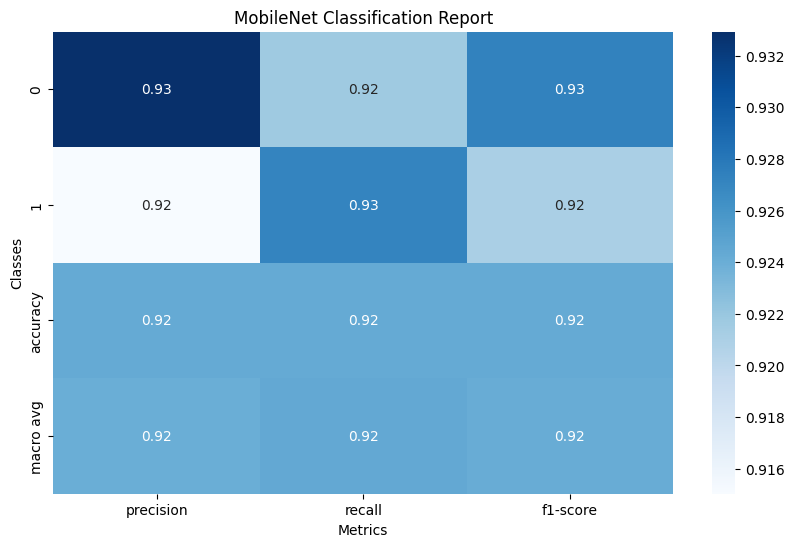

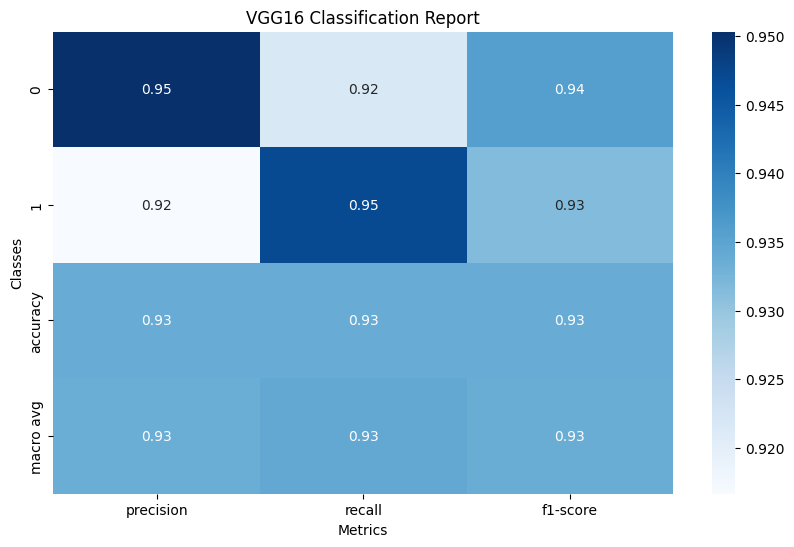

In [144]:
true_labels = test_generator.classes

cnn_report = classification_report(true_labels, cnn_pred_binary, output_dict=True)
mobilenet_report = classification_report(true_labels, mobilenet_pred_binary, output_dict=True)
vgg16_report = classification_report(true_labels, vgg16_pred_binary, output_dict=True)


cnn_df = pd.DataFrame(cnn_report).transpose()
mobilenet_df = pd.DataFrame(mobilenet_report).transpose()
vgg16_df = pd.DataFrame(vgg16_report).transpose()

def plot_classification_report(report_df, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
    plt.title(title)
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.show()


plot_classification_report(cnn_df, "CNN Classification Report")
plot_classification_report(mobilenet_df, "MobileNet Classification Report")
plot_classification_report(vgg16_df, "VGG16 Classification Report")

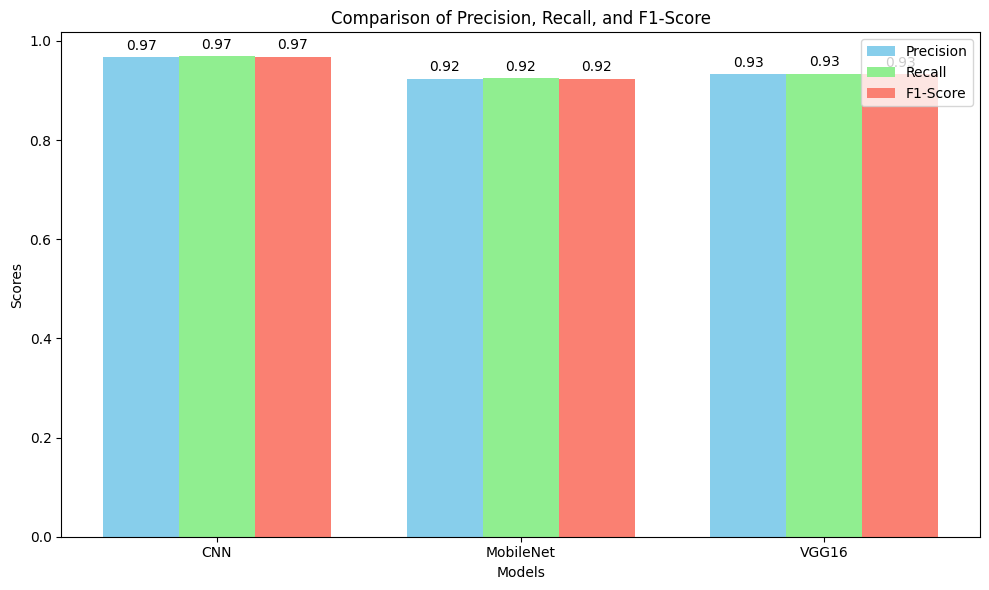

In [145]:
models = ["CNN", "MobileNet", "VGG16"]
precision = [
    cnn_report["macro avg"]["precision"],
    mobilenet_report["macro avg"]["precision"],
    vgg16_report["macro avg"]["precision"]
]
recall = [
    cnn_report["macro avg"]["recall"],
    mobilenet_report["macro avg"]["recall"],
    vgg16_report["macro avg"]["recall"]
]
f1_score = [
    cnn_report["macro avg"]["f1-score"],
    mobilenet_report["macro avg"]["f1-score"],
    vgg16_report["macro avg"]["f1-score"]
]


x = np.arange(len(models))  
width = 0.25  

fig, ax = plt.subplots(figsize=(10, 6))


rects1 = ax.bar(x - width, precision, width, label='Precision', color='skyblue')
rects2 = ax.bar(x, recall, width, label='Recall', color='lightgreen')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score', color='salmon')


ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision, Recall, and F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # مسافة النص
                    textcoords="offset points",
                    ha='center', va='bottom')


plt.tight_layout()
plt.show()